# Supervised Learning Capstone - Bank Telemarking Analysis <br>
This dataset contains information taken from the telemarking campaign of a portugese bank. The aim of the telemarketing campaign was to incur fixed term deposits. There are 20 variables and the outcome is whether a client subscribed to a deposit or not (binary; Yes/No).<br>

This notebook is a consolidated version of 6 working notebooks used to develop the following presentation: <br> https://github.com/imam2/DS-thinkful/blob/master/SupervisedLearning_Capstone_imnus_pdf.pdf <br>

It should also be noted that some of the findings will be different, due to the random nature of oversampling, cross validation and model application (random forest may be made of different trees, for example). The final version of the aforementioned notebooks, which describes some of the final results mentioned in the presentation, can be found here: <br>
https://github.com/imam2/imnus_Thinkful/blob/imam2-patch-1/Imnus_Thinkful_Supervised_Learning.ipynb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import scipy.stats as stats

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 5.0)

df = pd.read_csv('bank_full.csv', sep = ';')

df.head()

In [2]:
#checking for null values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [2]:
#creating functions that we will use during data processing, feature engineering and modelling
def standard(df):
    df = (df-df.mean())/df.std()
    return df

def norm(df):
    df = (df - df.mean()) / (df.max() - df.min())
    return df

#for objects I am not standardizing or normalizing because i am changing everything to binary classifiers
def prep_data_object(d):
    copy = d.copy(deep = True)
    copy = copy.select_dtypes(include=["object"])
    copy = pd.get_dummies(copy.drop('y',axis=1))
    #copy['y'] = d['y']
    #copy['y'] = np.where(d['y'] == 'yes', 1, 0)
    return copy

def prep_data_numeric(d,x):
    copy_1 = d.copy(deep = True)
    #copy_1 = convert_output_to_int(copy_1)
    copy_1 = copy_1.select_dtypes(include=['int32','float','int64'])
    print(copy_1.head())
    if x == "standard":
        copy_1 = standard(copy_1)
        return copy_1
    if x == "norm":
        copy_1 = norm(copy_1)
        return copy_1
    else:    
        return copy_1   

def all_var_numeric(a):
    a1 = prep_data_object(a)
    a2 = prep_data_numeric(a, "norm")
    return pd.concat([a1,a2], axis=1, sort=False)

def create_ind_dummies(t, c):
    t = t.loc[:,["c"]]
    t = prep_data_object(t)
    return t

def get_error(crosstab):
    tI_errors = crosstab.loc[0,1] / crosstab.loc['All','All'] * 100
    tII_errors = crosstab.loc[1,0] / crosstab.loc['All','All'] * 100
    print(('\nType I errors: {}%\nType II errors: {}%\n').format(round(tI_errors, 2), round(tII_errors, 2)))
    
def get_precision_recall(crosstab):
    precision = crosstab.loc[1,1] / crosstab.loc['All', 1] * 100 
    recall = crosstab.loc[1,1] / crosstab.loc[1,'All'] * 100 
    print(('Precision: {}%\nRecall: {}%').format(round(precision, 2), round(recall, 2)))

def fit_and_train(model):
    #test and train on the train itself.
    model_fit = model.fit(X, Y)
    model_score_train = model.score(X,Y)
    print('----Results based only on training dataset----')
    print('Accuracy:', model_score_train)
    
    train_crosstab = pd.crosstab(Y, model_fit.predict(X), rownames=['actual'], colnames=['predicted'], margins=True)
    print(train_crosstab)
    
    get_error(train_crosstab)
    get_precision_recall(train_crosstab)
    
    model_score_test = model.score(X_test, Y_test)
    print('\n----Results based on test dataset----')
    print('Accuracy:', model_score_test)
    
    test_crosstab = pd.crosstab(Y_test, model_fit.predict(X_test), rownames=['actual'], colnames=['predicted'], margins=True)
    print(test_crosstab)
    
    get_error(test_crosstab)
    get_precision_recall(test_crosstab)
    

## Understanding the dataset <br>

This dataset has 10 categorical object variables and 10 numerical continuous variables. They will be kept separate during the Univariate, Bivariate Analysis of this notebook. 
<br>
#### Categorical (object) variables <br>
- Job : Occupation
- Marital : Marital status
- Education : Educational background
- Housing : Housing loan (yes/no)
- Default : Credit default (yes/no)
- Loan : Personal loan (yes/no)
- Contact : Method of contact (cellular/telephone)
- Month : Month of the year of contact
- Day_of_week : day of the week of contact
- Poutcome : outcome of previous campaign (yes/no, did they subscribe last time?) <br>
#### Continuous (numerical) variables <br>
- Age : Age of client
- Duration : Duration of call
- Campaign : number of times called made to client
- Pdays : Numer of days since last contact (from previous campaign
- Previous : Number of calls in previous campaign
- Emp.var.rate : Employment variation rate (quarterly)
- cons.price.idx : Consumer price index (monthly)
- cons.conf.idx : Consumder confidence index (monthly)
- Euribor3m : Euro interbank interest rate (daily)
- nr.employed: Number of employees (quarterly) <br>


In [3]:
print(df.dtypes)

# Creating a pandas dataframe containing numerical independant variables
df_num = df.select_dtypes(include=['int32','float','int64'])

def convert_output_to_int(d):
    d["y"] = np.where(d["y"] == 'yes', 1, 0)
    return d["y"]

df_num["y"] = convert_output_to_int(df)
print(df_num.columns)
df_num.head()

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


c:\users\imnus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


## Univariate, bivariate analysis of numerical variables

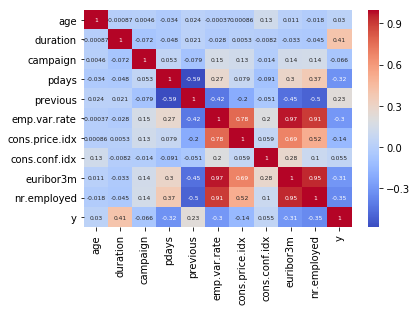

In [92]:
corr = df_num.corr()
sns.heatmap(corr, cmap = 'coolwarm' , annot=True, annot_kws={"size": 6})
plt.show()

#### Conclusion from heatmap <br>
1) High correlations between nr.employed, euribor3m (interest rates), emp.var.rate, previous (outcome), pdays and duration variables. <br>
2) High correlations between emp.var.rate, cons.price.idx, euribor3m (interest rates) and nr.employed

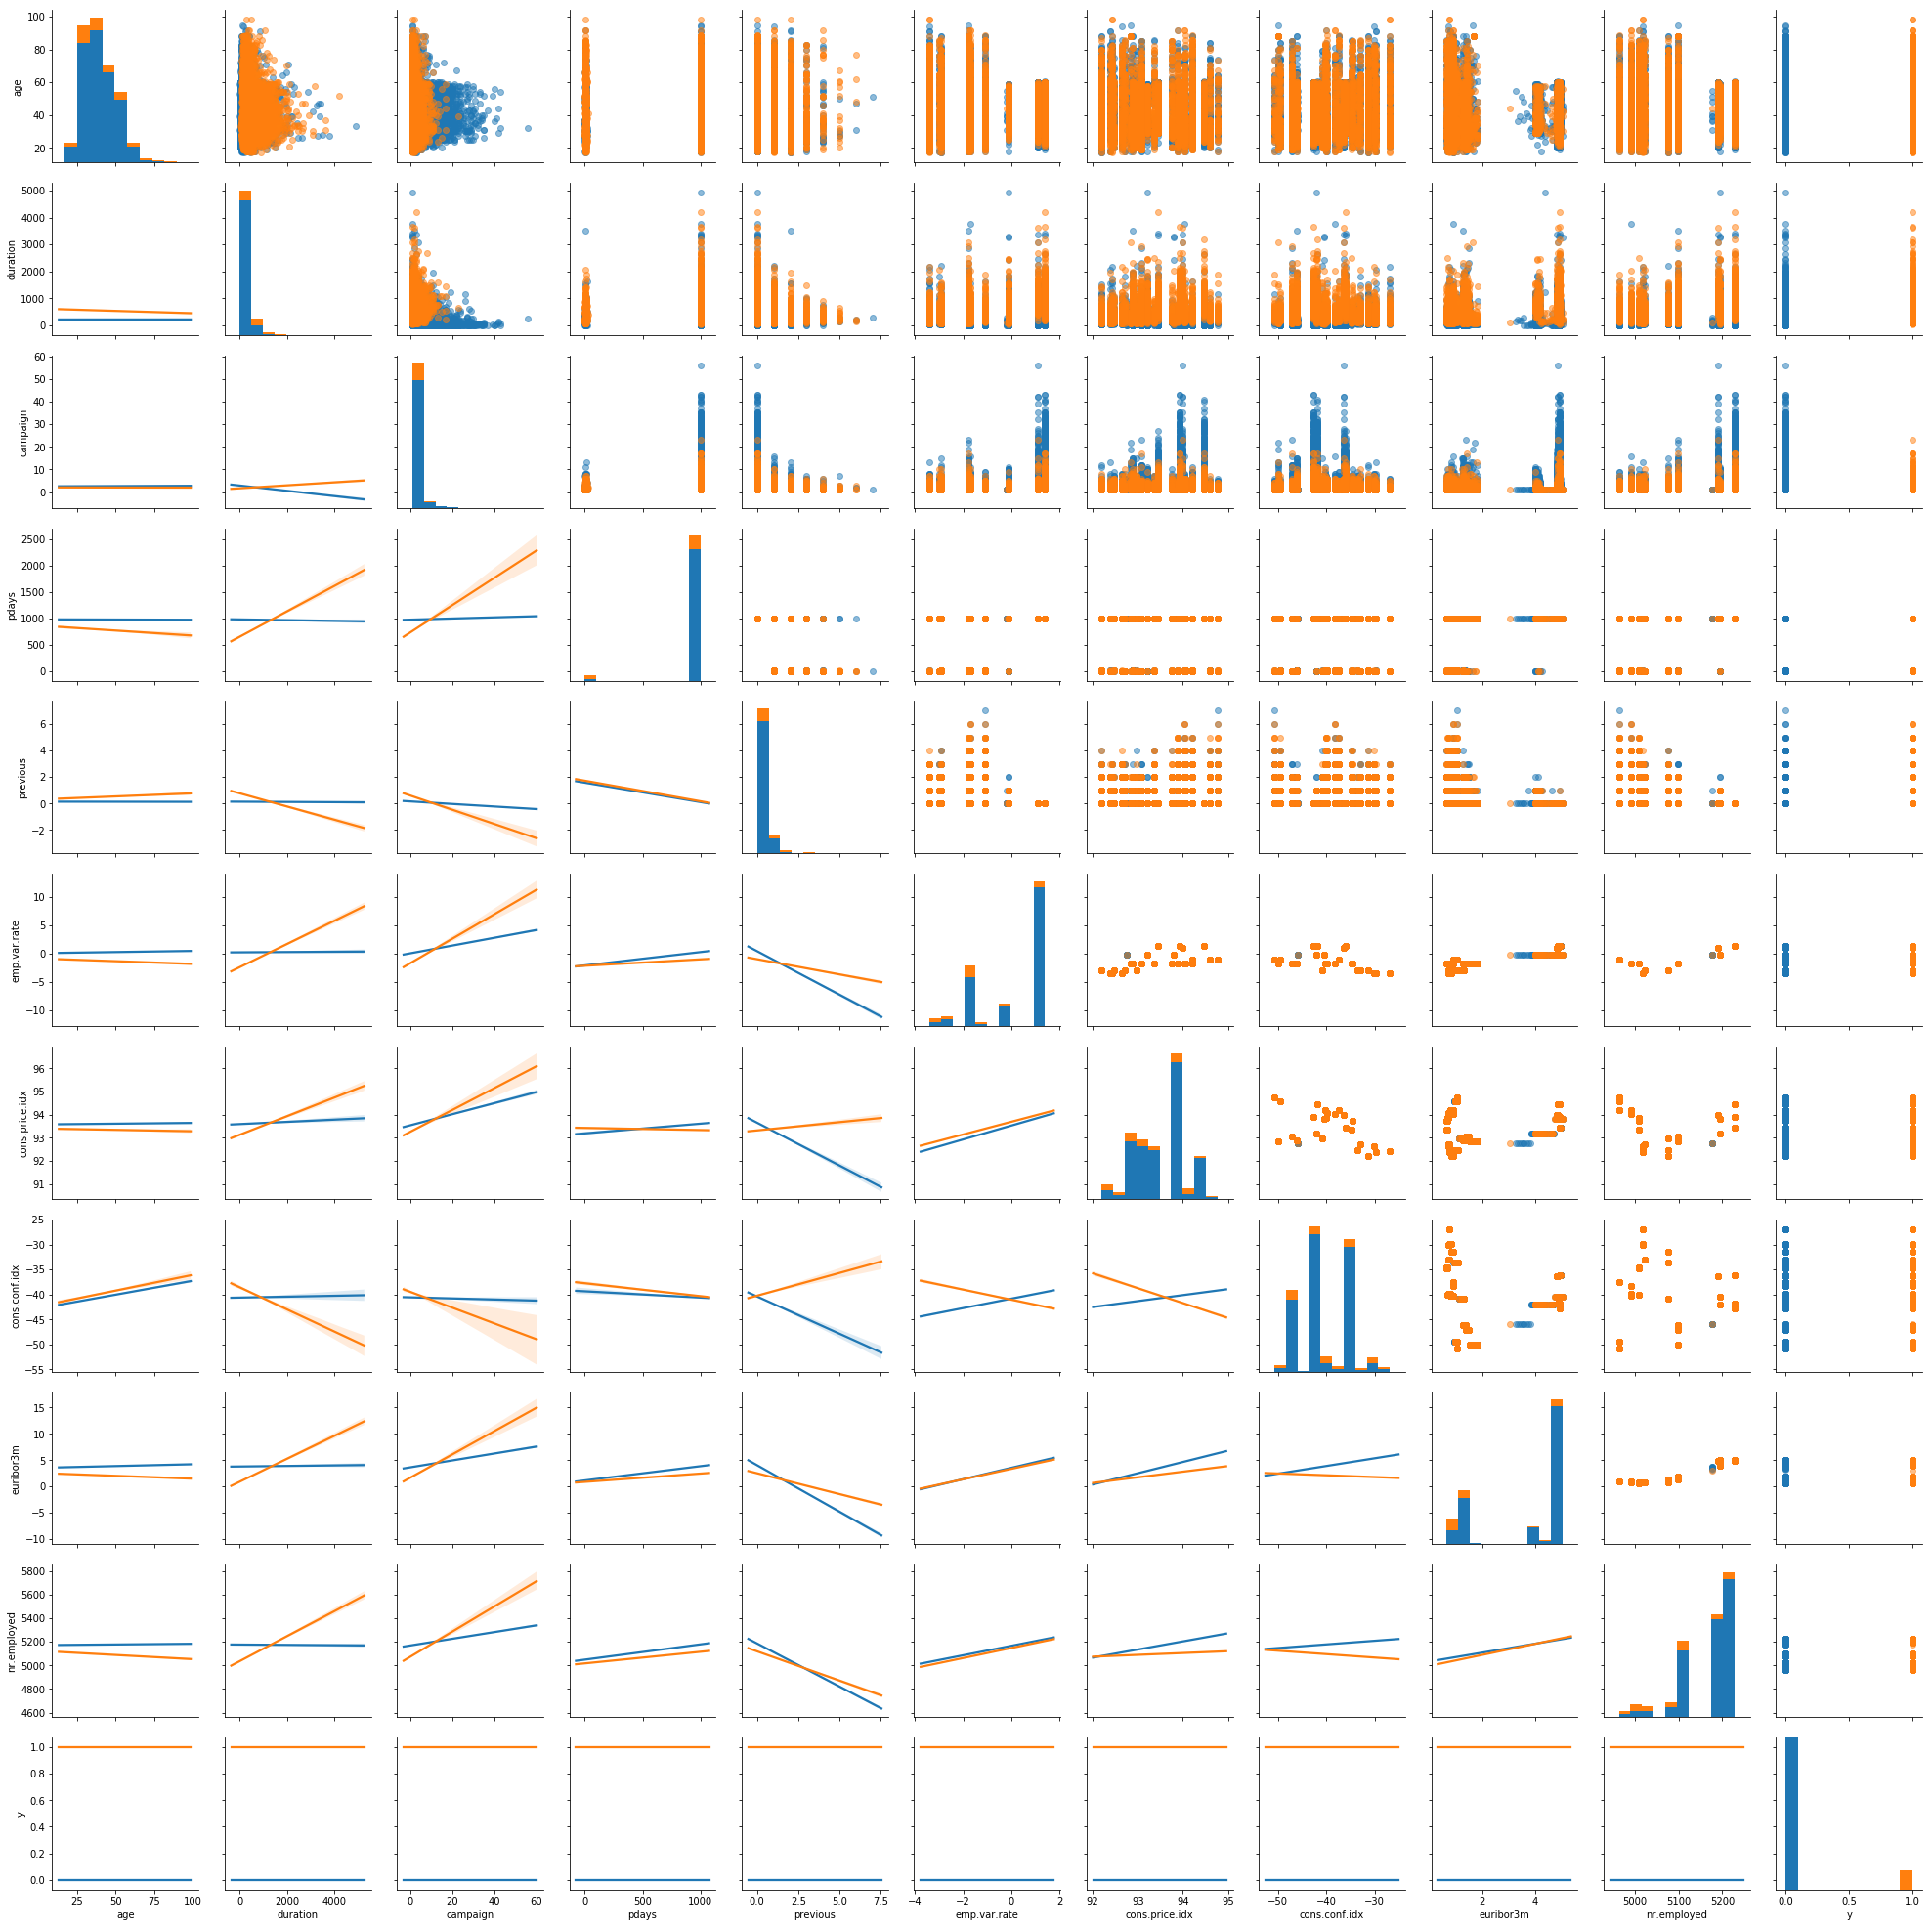

In [5]:
g = sns.PairGrid(df_num, diag_sharey=False, hue = 'y')
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(plt.hist, lw=3)
plt.show()

In [6]:
#looking at unique values for euribor3m (european interest rates) and campaign (number of calls per client)
print(df_num['euribor3m'].unique())
df_num['campaign'].unique()

[4.857 4.856 4.855 4.859 4.86  4.858 4.864 4.865 4.866 4.967 4.961 4.959
 4.958 4.96  4.962 4.955 4.947 4.956 4.966 4.963 4.957 4.968 4.97  4.965
 4.964 5.045 5.    4.936 4.921 4.918 4.912 4.827 4.794 4.76  4.733 4.7
 4.663 4.592 4.474 4.406 4.343 4.286 4.245 4.223 4.191 4.153 4.12  4.076
 4.021 3.901 3.879 3.853 3.816 3.743 3.669 3.563 3.488 3.428 3.329 3.282
 3.053 1.811 1.799 1.778 1.757 1.726 1.703 1.687 1.663 1.65  1.64  1.629
 1.614 1.602 1.584 1.574 1.56  1.556 1.548 1.538 1.531 1.52  1.51  1.498
 1.483 1.479 1.466 1.453 1.445 1.435 1.423 1.415 1.41  1.405 1.406 1.4
 1.392 1.384 1.372 1.365 1.354 1.344 1.334 1.327 1.313 1.299 1.291 1.281
 1.266 1.25  1.244 1.259 1.264 1.27  1.262 1.26  1.268 1.286 1.252 1.235
 1.224 1.215 1.206 1.099 1.085 1.072 1.059 1.048 1.044 1.029 1.018 1.007
 0.996 0.979 0.969 0.944 0.937 0.933 0.927 0.921 0.914 0.908 0.903 0.899
 0.884 0.883 0.881 0.879 0.873 0.869 0.861 0.859 0.854 0.851 0.849 0.843
 0.838 0.834 0.829 0.825 0.821 0.819 0.813 0.809 0.803 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 19, 18, 23, 14,
       22, 25, 16, 17, 15, 20, 56, 39, 35, 42, 28, 26, 27, 32, 21, 24, 29,
       31, 30, 41, 37, 40, 33, 34, 43], dtype=int64)

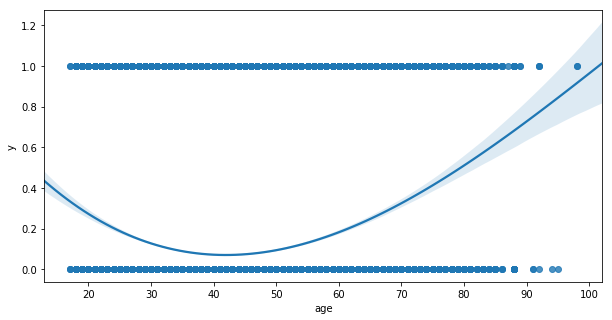

In [38]:
#age vs outcome
ax = sns.regplot(x='age', y= 'y', order=3, data=df_num)

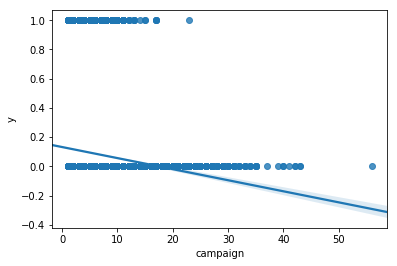

In [6]:
#shows that calling an individual more than 20 times is useless
ax = sns.regplot(x='campaign', y= 'y', order=1, data=df_num)

## Univariate, bivariate analysis of  categorical variables

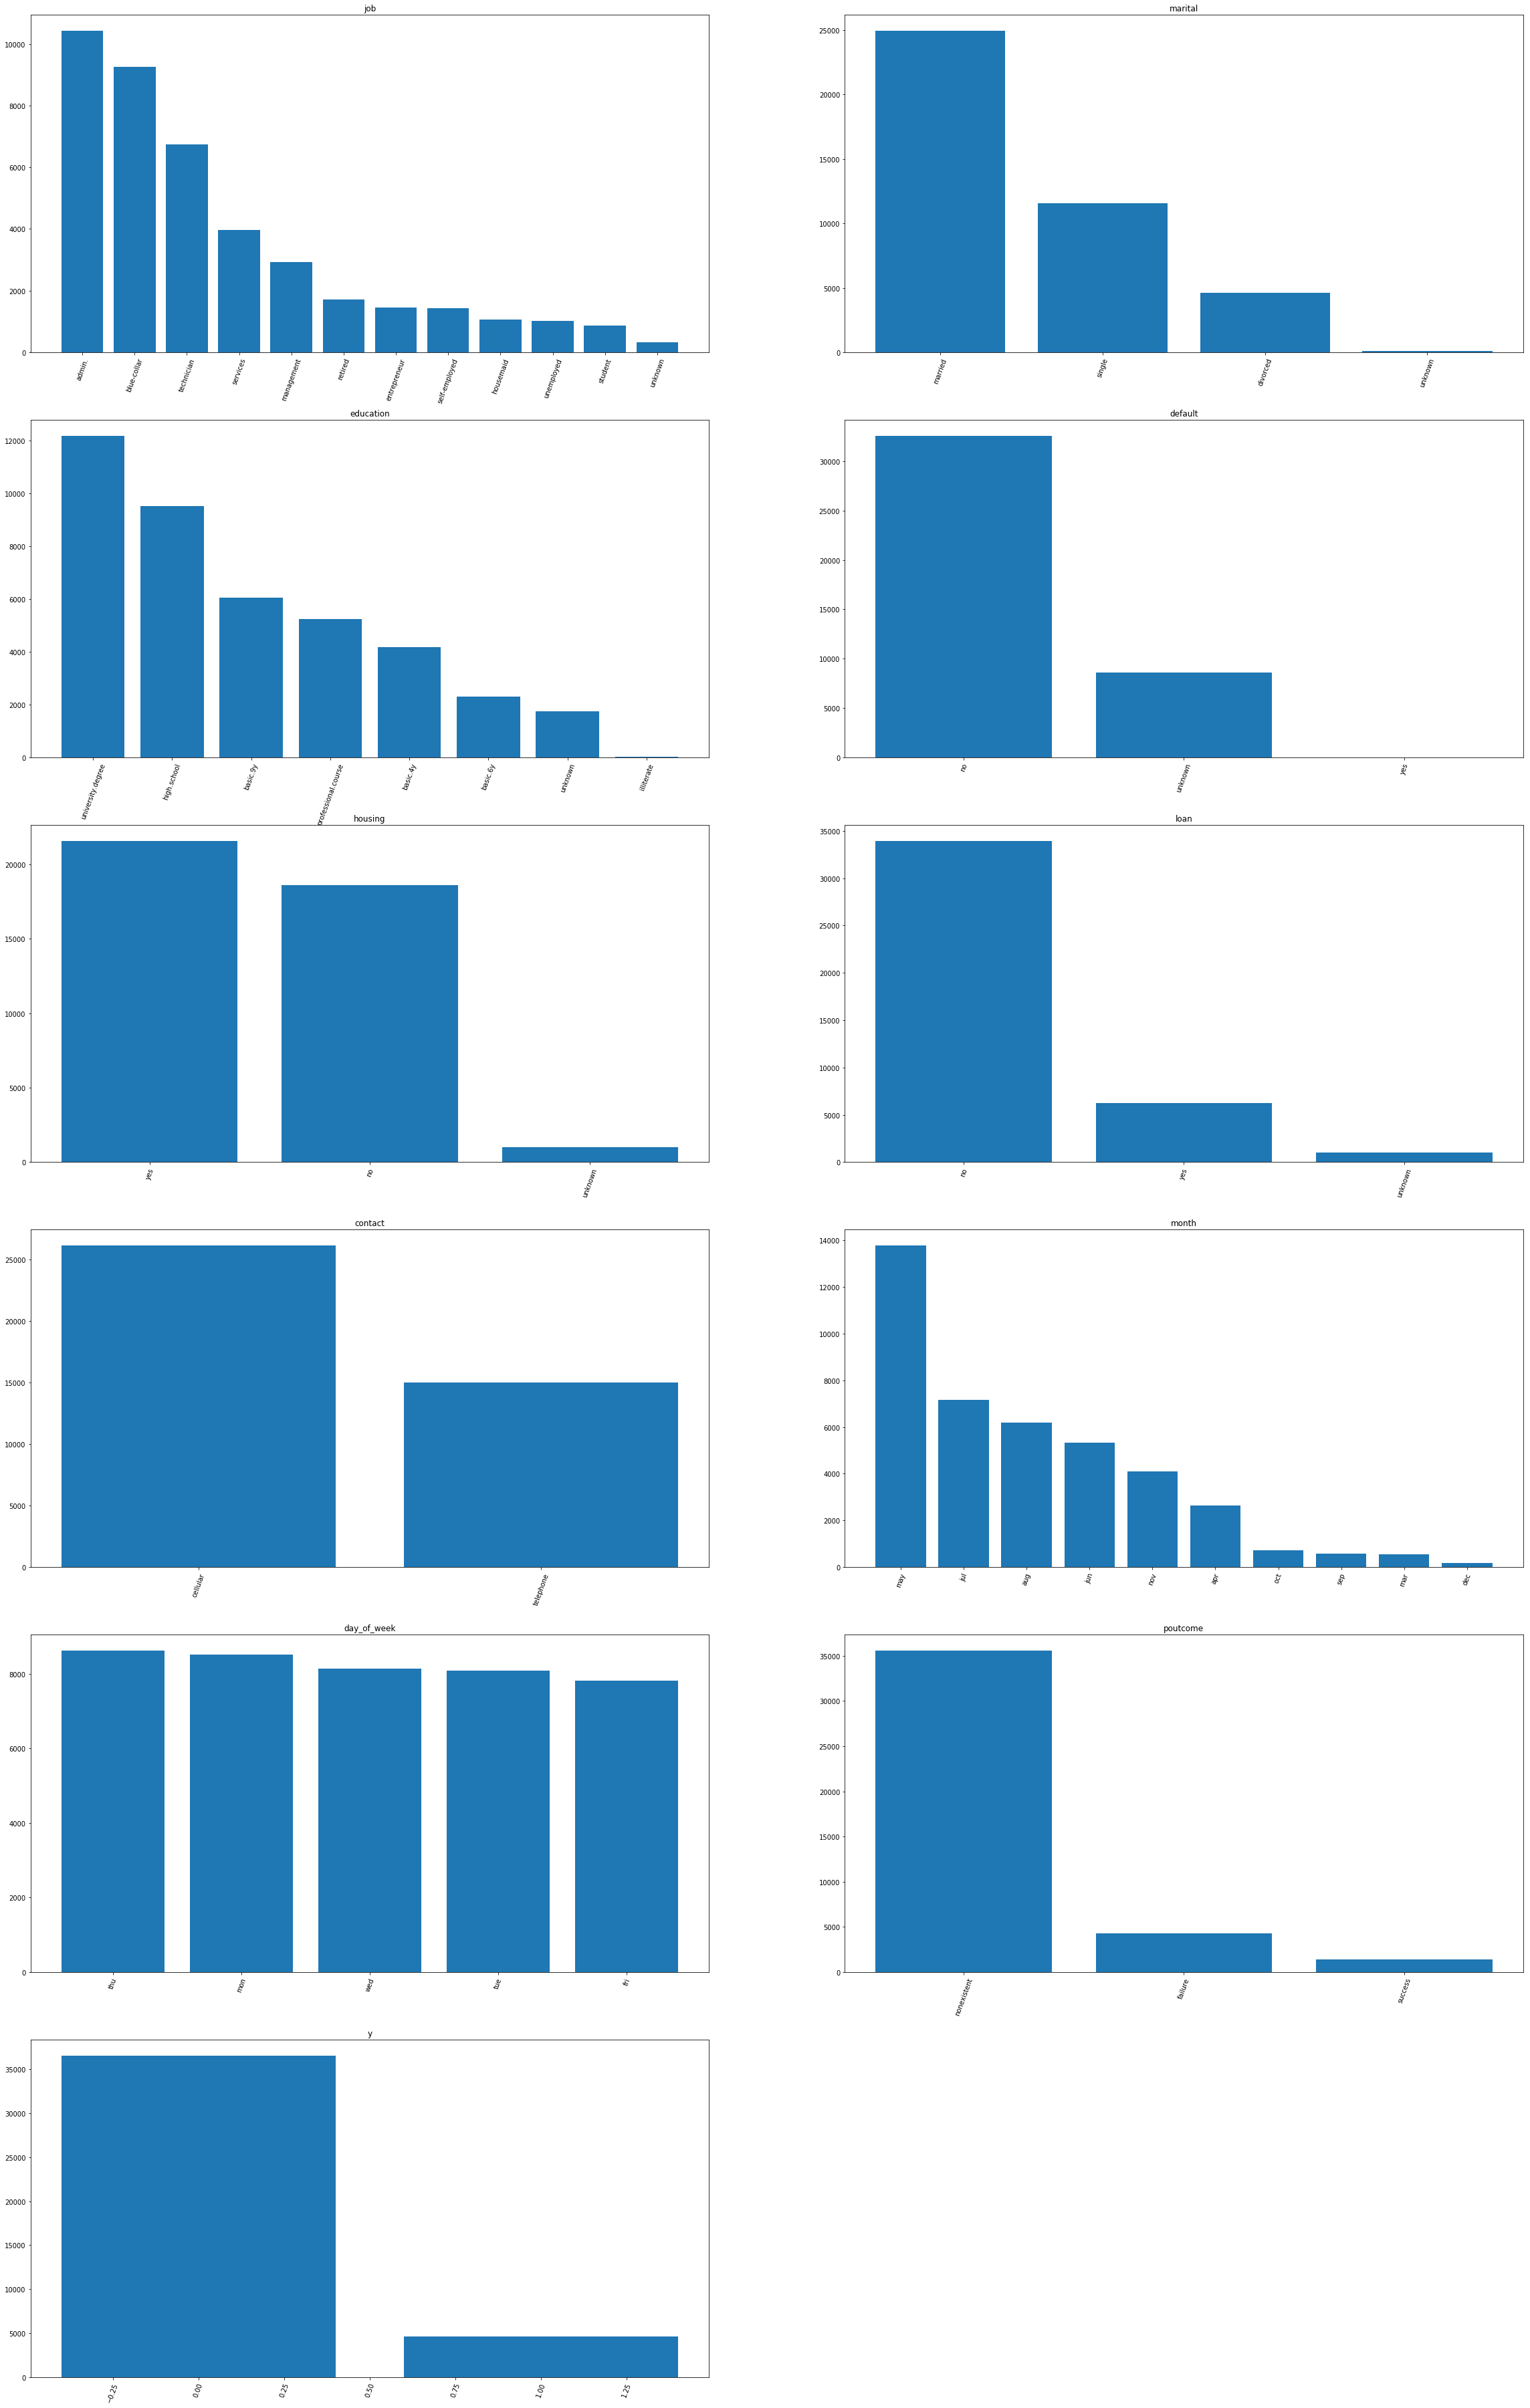

In [7]:
#categoricals -- count per category
categoricals = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y']

def bar_chart_categorical(d):
    plt.figure(figsize = (40,65))
    for i, col in enumerate(categoricals):
        plt.subplot(6,2,i+1)
        plt.bar(df[col].value_counts().index, height = df[col].value_counts())
        plt.xticks(rotation=70)
        plt.title(col)
    plt.show()

bar_chart_categorical(df)

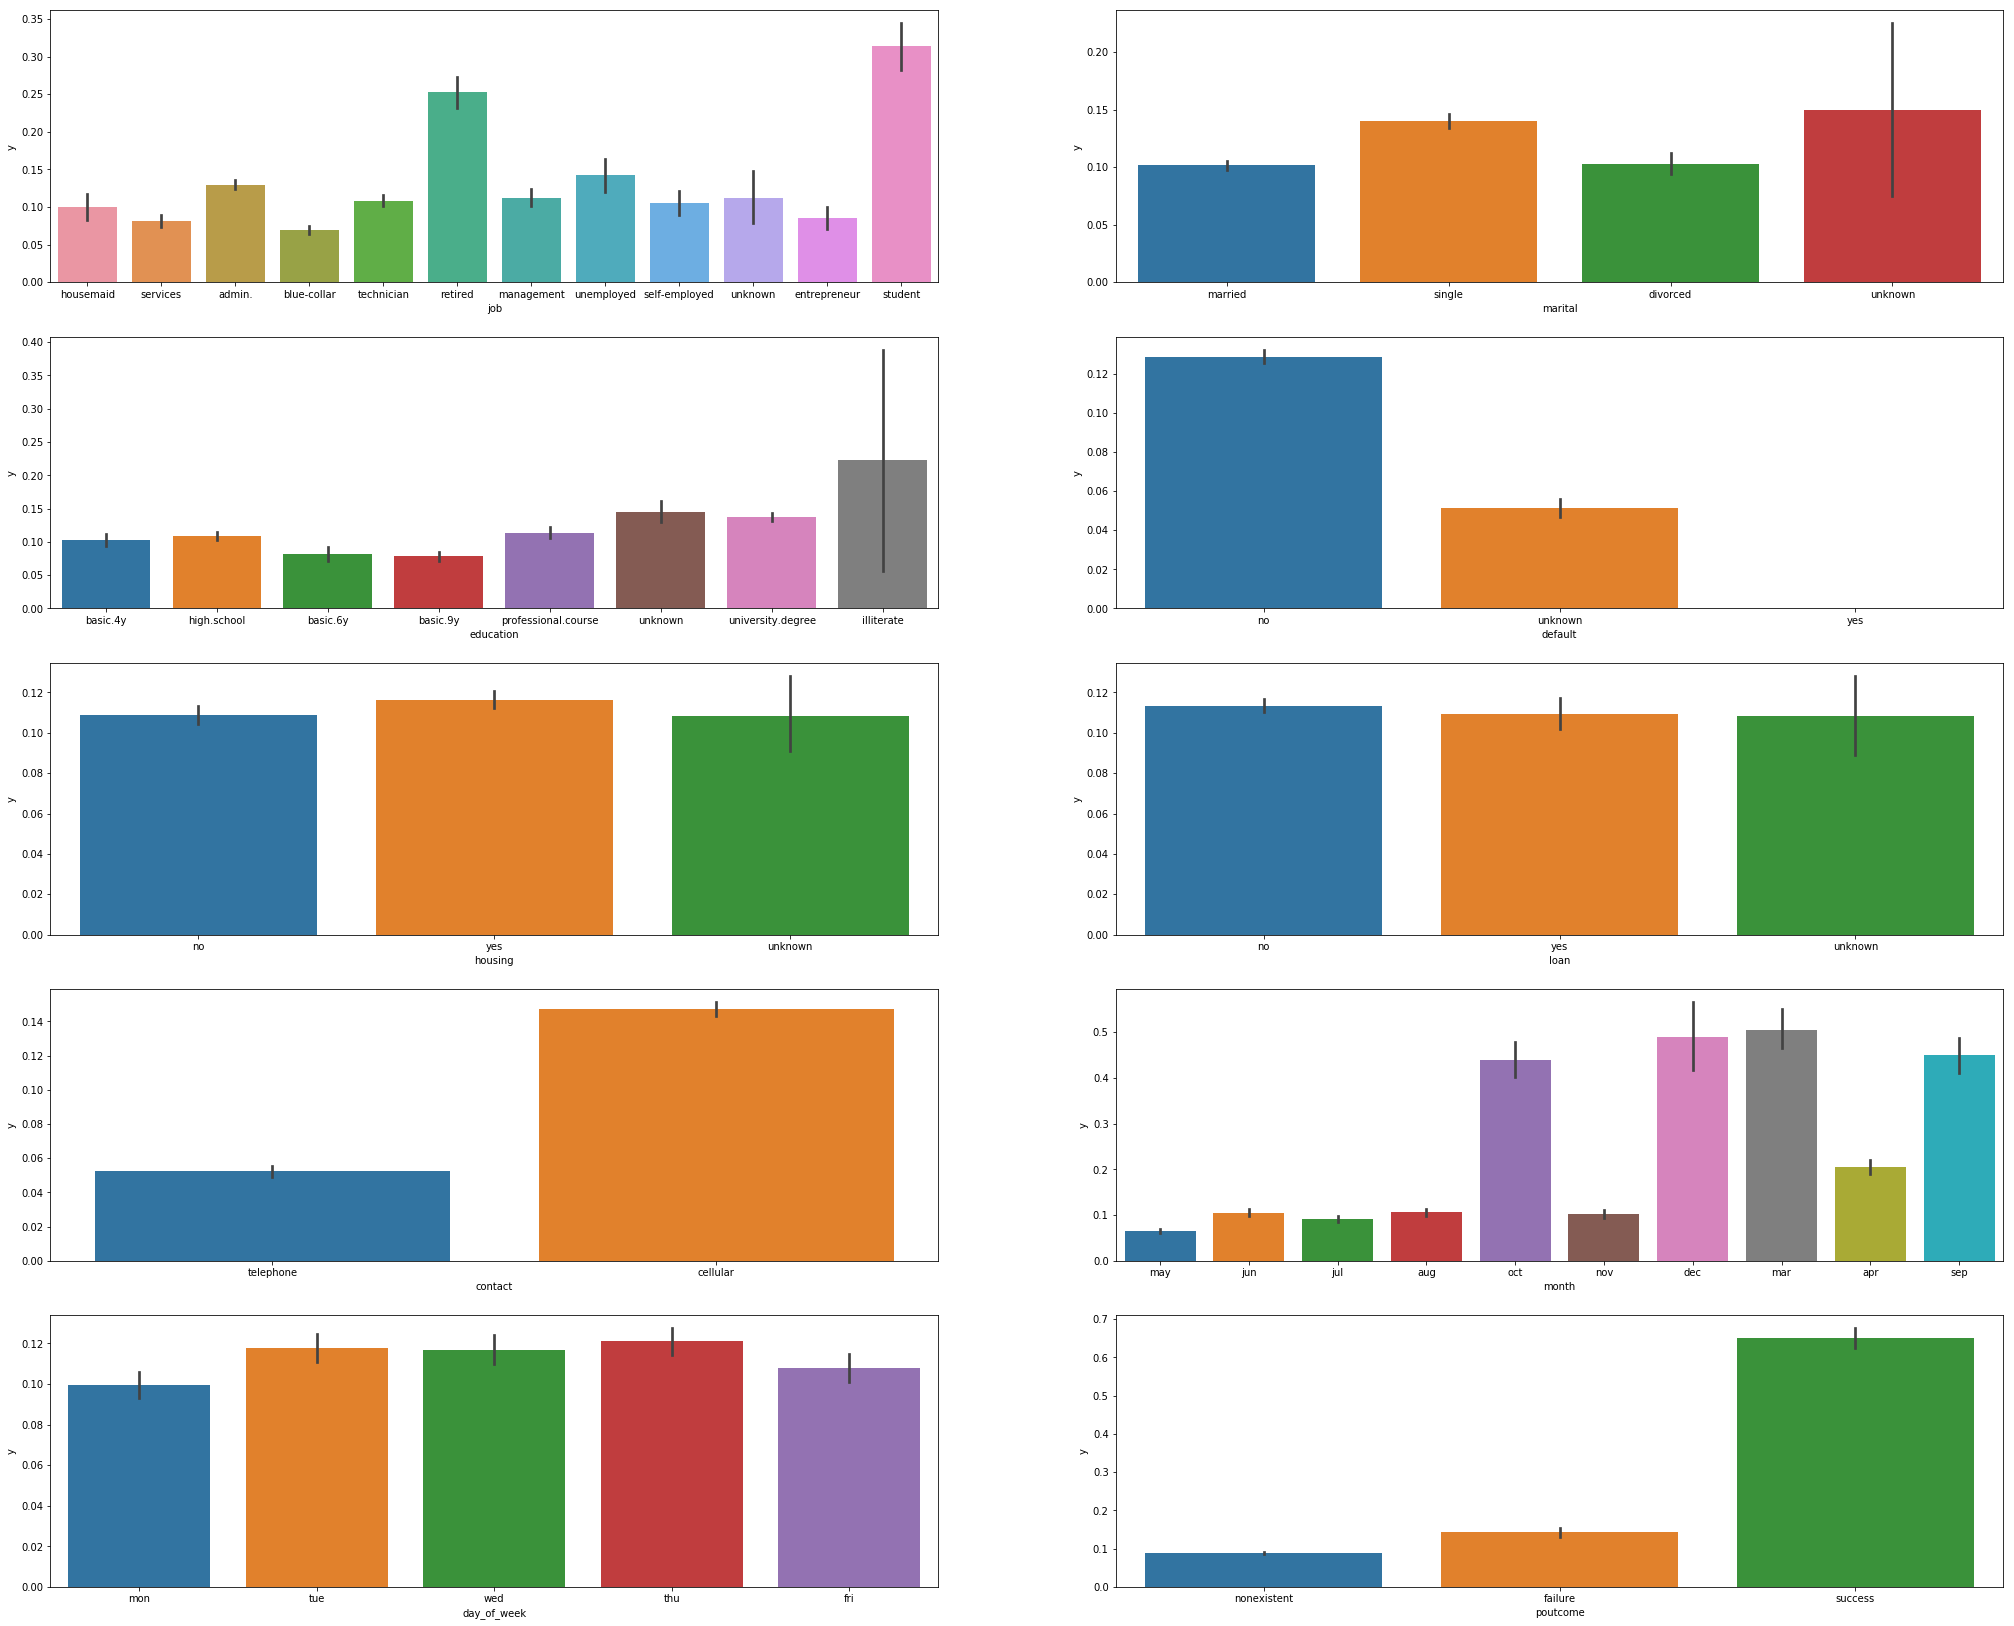

In [8]:
# categoricals -- success rate per category
categoricals = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome']
df = pd.read_csv('bank_full.csv', sep = ';')

df['y'] = np.where(df['y'] == 'yes', 1, 0)
def sns_barplot_categorical(d):
    plt.figure(figsize = (35,35))
    #sns.set_color_codes("color")
    for i, col in enumerate(categoricals):
        plt.subplot(6,2,i+1)
        sns.barplot(x=col, y="y", data=df,
            label="T")
sns_barplot_categorical(df)

#### Conclusion from barplots of outcome (y = yes/no) vs categorical variables <br>
- Students and retired people have a greater likelyhood of making a deposit
- People who identify as Illiterate have a greater likelyhood of making a deposit. However, a large error bar indicates the presence of outliers
- Certain months have a higher success rate ( March, April, Sept, Oct, Dec)

In [4]:
#one hot encoding the categoricals
object_var = df.loc[:,['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome']]
print(object_var.shape)

def prep_data_object(d):
    copy = d.copy(deep = True)
    #copy = copy.select_dtypes(include=["object"])
    copy = pd.get_dummies(copy)
    #copy['y'] = d['y']
    #copy['y'] = np.where(d['y'] == 'yes', 1, 0)
    return copy

object_var = prep_data_object(object_var)
print(object_var.shape)
object_var.describe()

(41188, 10)
(41188, 53)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,...,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,...,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
#combined all variables into one combined dataframe
allfeat_df =  pd.concat([object_var,df_num], axis=1, sort=False)
allfeat_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,0,0,1,0,0,0,0,0,0,...,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,0,0,0,0,0,0,0,1,0,0,...,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,0,0,0,0,0,0,0,1,0,0,...,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,1,0,0,0,0,0,0,0,0,0,...,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,0,0,0,0,0,0,0,1,0,0,...,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [95]:
# will implement test/train split
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(allfeat_df.loc[:,['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'age', 'duration',
       'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']], allfeat_df['y'], test_size= 0.20, random_state=20)
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(32950, 63)
(32950,)
(8238, 63)
(8238,)


In [96]:
#checking the orientation of the data
print(type(X))
print(type(Y))
print(type(X_test))
type(Y_test)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


pandas.core.series.Series

### Initial Modelling <br>
- For all purposes, the dataframes "X" and "Y" will serve as our train data sets. X is the input (consisting of variables/features) and Y is the output.
- We are going to train and test on all 63 features - 10 numerical plus 53 one hot encoded features extracted from the 10 categorical features. <br>

The models that we will use are:<br>
- Random forest classifier
- K nearest neighbours
- Logistic Regression
- Support vector classifiers
- Linear support vector classifier

In [24]:
#now we will test the models with all 63 features. 
#tuning the variables that I can tune without being computationally too exhaustive

#tuning random forest.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble


rfc = ensemble.RandomForestClassifier()

params = {"n_estimators": [10, 5, 15],
              "max_depth": [3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.0]}



grid = GridSearchCV(estimator=rfc, param_grid=params, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

#checking CV score on base rfc model
cross_val_score(rfc, X, Y, cv=10)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   15.7s finished


array([0.9047041 , 0.90743551, 0.9138088 , 0.9016692 , 0.90440061,
       0.90561457, 0.9016692 , 0.90864947, 0.91229135, 0.90713202])

In [27]:
#best estimator from Gridsearch
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

----Results based only on training dataset----
Accuracy: 0.9020940819423369
predicted      0     1    All
actual                       
0          28956   264  29220
1           2962   768   3730
All        31918  1032  32950

Type I errors: 0.8%
Type II errors: 8.99%

Precision: 74.42%
Recall: 20.59%

----Results based on test dataset----
Accuracy: 0.9016751638747269
predicted     0    1   All
actual                    
0          7266   62  7328
1           748  162   910
All        8014  224  8238

Type I errors: 0.75%
Type II errors: 9.08%

Precision: 72.32%
Recall: 17.8%


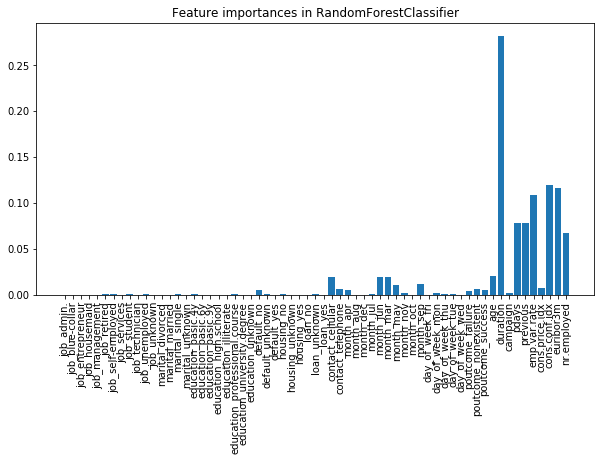

In [29]:
rfc  = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#fit,train and plot feat_importances
fit_and_train(rfc)
plt.figure(figsize=(10,5))
plt.bar(X.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

In [30]:
cross_val_score(rfc, X, Y, cv=10)
cross_val_score(rfc, X_test, Y_test, cv=10)

array([0.90048544, 0.89684466, 0.89684466, 0.89563107, 0.90169903,
       0.90291262, 0.8907767 , 0.90169903, 0.90036452, 0.90886999])

----Results based only on training dataset----
Accuracy: 0.9933535660091047
predicted      0     1    All
actual                       
0          29208    12  29220
1            207  3523   3730
All        29415  3535  32950

Type I errors: 0.04%
Type II errors: 0.63%

Precision: 99.66%
Recall: 94.45%

----Results based on test dataset----
Accuracy: 0.9092012624423403
predicted     0    1   All
actual                    
0          7131  197  7328
1           551  359   910
All        7682  556  8238

Type I errors: 2.39%
Type II errors: 6.69%

Precision: 64.57%
Recall: 39.45%


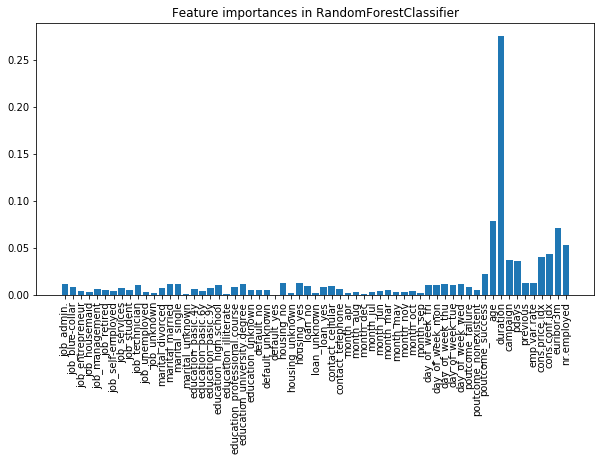

array([0.89684466, 0.91019417, 0.89684466, 0.89927184, 0.90898058,
       0.91383495, 0.88834951, 0.88956311, 0.90522479, 0.90643985])

In [33]:
#CV scores look good.
#interesting that this looks different
#different set of trees?

#checking base(default rfc performance)
rfc  = ensemble.RandomForestClassifier()

#fit,train and plot feat_importances
fit_and_train(rfc)
plt.figure(figsize=(10,5))
plt.bar(X.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

#CV scores
cross_val_score(rfc, X, Y, cv=10)
print(cross_val_score(rfc, X_test, Y_test, cv=10))

*Will now check the results from other models without tuning to get an idea of what performance looks like*

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
fit_and_train(knn)

print(cross_val_score(knn, X, Y, cv=10))
print(cross_val_score(knn, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.9312594840667678
predicted      0     1    All
actual                       
0          28409   811  29220
1           1454  2276   3730
All        29863  3087  32950

Type I errors: 2.46%
Type II errors: 4.41%

Precision: 73.73%
Recall: 61.02%

----Results based on test dataset----
Accuracy: 0.9053168244719592
predicted     0    1   All
actual                    
0          7014  314  7328
1           466  444   910
All        7480  758  8238

Type I errors: 3.81%
Type II errors: 5.66%

Precision: 58.58%
Recall: 48.79%
[0.90045524 0.90257967 0.90834598 0.90106222 0.90075873 0.90409712
 0.90440061 0.91016692 0.91107739 0.90136571]
[0.90533981 0.90533981 0.92597087 0.91626214 0.90776699 0.91140777
 0.88834951 0.90169903 0.90643985 0.91251519]


In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

fit_and_train(lr)

print(cross_val_score(lr, X, Y, cv=10))
print(cross_val_score(lr, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.9099241274658574
predicted      0     1    All
actual                       
0          28444   776  29220
1           2192  1538   3730
All        30636  2314  32950

Type I errors: 2.36%
Type II errors: 6.65%

Precision: 66.46%
Recall: 41.23%

----Results based on test dataset----
Accuracy: 0.9122359796067007
predicted     0    1   All
actual                    
0          7150  178  7328
1           545  365   910
All        7695  543  8238

Type I errors: 2.16%
Type II errors: 6.62%

Precision: 67.22%
Recall: 40.11%
[0.91198786 0.91532625 0.91411229 0.90440061 0.90379363 0.90652504
 0.91198786 0.91107739 0.9107739  0.907739  ]
[0.91626214 0.91626214 0.91990291 0.91747573 0.91504854 0.91990291
 0.90533981 0.90412621 0.90765492 0.91008505]


In [38]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
fit_and_train(clf)
print(cross_val_score(clf, X_test, Y_test, cv=10))
print(cross_val_score(clf, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.8884673748103187
predicted      0    1    All
actual                      
0          29167   53  29220
1           3622  108   3730
All        32789  161  32950

Type I errors: 0.16%
Type II errors: 10.99%

Precision: 67.08%
Recall: 2.9%

----Results based on test dataset----
Accuracy: 0.891357125515902
predicted     0   1   All
actual                   
0          7320   8  7328
1           887  23   910
All        8207  31  8238

Type I errors: 0.1%
Type II errors: 10.77%

Precision: 74.19%
Recall: 2.53%
[0.90169903 0.89684466 0.89199029 0.90048544 0.9065534  0.90898058
 0.89684466 0.89563107 0.89671932 0.90157959]
[0.90412621 0.91504854 0.91262136 0.85315534 0.89927184 0.91019417
 0.88713592 0.89684466 0.89671932 0.90279465]


In [97]:
from sklearn.svm import SVC
svc = SVC()
fit_and_train(svc)
cross_val_score(svc, X, Y, cv=10)
#leaving cross value score on X_test and Y_test out to conserve time

----Results based only on training dataset----
Accuracy: 0.9592716236722306
predicted      0     1    All
actual                       
0          29064   156  29220
1           1186  2544   3730
All        30250  2700  32950

Type I errors: 0.47%
Type II errors: 3.6%

Precision: 94.22%
Recall: 68.2%

----Results based on test dataset----
Accuracy: 0.8974265598446225
predicted     0    1   All
actual                    
0          7142  186  7328
1           659  251   910
All        7801  437  8238

Type I errors: 2.26%
Type II errors: 8.0%

Precision: 57.44%
Recall: 27.58%


array([0.89893778, 0.89347496, 0.89499241, 0.89590288, 0.89377845,
       0.89863429, 0.89499241, 0.89620637, 0.89772382, 0.8952959 ])

In [ ]:
#paused the result above because I don't care about CV score . will now oversample.

In [7]:
#dealing with class imbalance
from imblearn.over_sampling import SMOTE
smote =  SMOTE(random_state = 1, ratio = 1.0)
xx = X
yy = Y

x_balanced,y_balanced = smote.fit_sample(xx,yy)

print(x_balanced.shape)
print(y_balanced.shape)

x_var = list(xx.columns)
bal_df = pd.DataFrame(data = x_balanced , columns = x_var)
bal_df.describe()

c:\users\imnus\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(58440, 63)
(58440,)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.00000,58440.000000,58440.000000,58440.000000,...,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000
mean,0.272998,0.189336,0.032716,0.024092,0.072435,0.061268,0.03181,0.084471,0.035564,0.159984,...,40.191807,387.063530,2.311677,885.051912,0.315042,-0.493880,93.480670,-40.221687,2.967480,5135.764410
std,0.411569,0.370245,0.166019,0.143464,0.239104,0.225784,0.16381,0.261334,0.167496,0.340240,...,11.473072,359.325202,2.273270,316.523587,0.667994,1.718084,0.619153,5.199099,1.888033,86.691177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,31.636688,144.796492,1.000000,999.000000,0.000000,-1.800000,92.941999,-42.700000,1.244000,5076.200000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,37.485848,265.000000,1.920485,999.000000,0.000000,-0.100000,93.444000,-41.391856,4.021000,5191.000000
75%,0.633739,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,47.156462,523.000000,2.852989,999.000000,0.088031,1.400000,93.994000,-36.400000,4.958665,5228.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
#intializing new over sampled test dataset
X = bal_df
Y = y_balanced

print(X.shape)
print(Y.shape)

#checking if oversampling mitigated class imbalance (IT DOES!)
np.mean(y_balanced)

(58440, 63)
(58440,)


0.5

In [43]:
#repeat of cells 24-42. will leave out Cross validation on test to save time. 
#tuning random forest.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble


rfc = ensemble.RandomForestClassifier()

params = {"n_estimators": [10, 5, 15],
              "max_depth": [3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.0]}



grid = GridSearchCV(estimator=rfc, param_grid=params, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

#checking CV score on base rfc model
cross_val_score(rfc, X, Y, cv=10)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   39.1s finished


array([0.61738535, 0.90776865, 0.98271732, 0.97878166, 0.98066393,
       0.98083504, 0.97792608, 0.98237509, 0.97963723, 0.97912389])

In [44]:
#best estimator from Gridsearch
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=40,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

----Results based only on training dataset----
Accuracy: 0.9151266255989049
predicted      0      1    All
actual                        
0          26251   2969  29220
1           1991  27229  29220
All        28242  30198  58440

Type I errors: 5.08%
Type II errors: 3.41%

Precision: 90.17%
Recall: 93.19%

----Results based on test dataset----
Accuracy: 0.8773974265598447
predicted     0     1   All
actual                     
0          6611   717  7328
1           293   617   910
All        6904  1334  8238

Type I errors: 8.7%
Type II errors: 3.56%

Precision: 46.25%
Recall: 67.8%


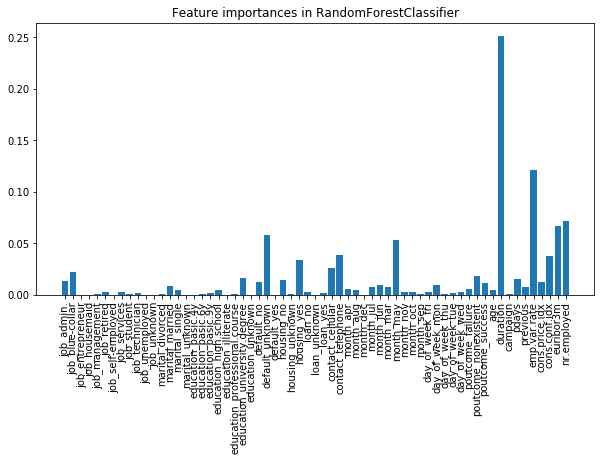

array([0.75136893, 0.90297741, 0.94010951, 0.93463381, 0.93069815,
       0.92881588, 0.93685832, 0.93583162, 0.93377823, 0.93566051])

In [46]:
rfc  = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=40,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#fit,train and plot feat_importances
fit_and_train(rfc)
plt.figure(figsize=(10,5))
plt.bar(X.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

cross_val_score(rfc, X, Y, cv=10)

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
fit_and_train(knn)

print(cross_val_score(knn, X, Y, cv=10))
print(cross_val_score(knn, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.9393052703627652
predicted      0      1    All
actual                        
0          25892   3328  29220
1            219  29001  29220
All        26111  32329  58440

Type I errors: 5.69%
Type II errors: 0.37%

Precision: 89.71%
Recall: 99.25%

----Results based on test dataset----
Accuracy: 0.8469288662296673
predicted     0     1   All
actual                     
0          6273  1055  7328
1           206   704   910
All        6479  1759  8238

Type I errors: 12.81%
Type II errors: 2.5%

Precision: 40.02%
Recall: 77.36%
[0.91683778 0.92111567 0.92453799 0.91872005 0.91718001 0.92316906
 0.91444216 0.92111567 0.92402464 0.9192334 ]
[0.90533981 0.90533981 0.92597087 0.91626214 0.90776699 0.91140777
 0.88834951 0.90169903 0.90643985 0.91251519]


In [49]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

fit_and_train(lr)

print(cross_val_score(lr, X, Y, cv=10))
print(cross_val_score(lr, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.8754791238877481
predicted      0      1    All
actual                        
0          25118   4102  29220
1           3175  26045  29220
All        28293  30147  58440

Type I errors: 7.02%
Type II errors: 5.43%

Precision: 86.39%
Recall: 89.13%

----Results based on test dataset----
Accuracy: 0.868050497693615
predicted     0     1   All
actual                     
0          6356   972  7328
1           115   795   910
All        6471  1767  8238

Type I errors: 11.8%
Type II errors: 1.4%

Precision: 44.99%
Recall: 87.36%
[0.87457221 0.87816564 0.87850787 0.87371663 0.87183436 0.87525667
 0.8646475  0.87594114 0.87645448 0.87748118]
[0.91626214 0.91626214 0.91990291 0.91747573 0.91504854 0.91990291
 0.90533981 0.90412621 0.90765492 0.91008505]


In [50]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
fit_and_train(clf)
print(cross_val_score(clf, X, Y, cv=10))

----Results based only on training dataset----
Accuracy: 0.7856947296372347
predicted      0      1    All
actual                        
0          17063  12157  29220
1            367  28853  29220
All        17430  41010  58440

Type I errors: 20.8%
Type II errors: 0.63%

Precision: 70.36%
Recall: 98.74%

----Results based on test dataset----
Accuracy: 0.6301286720077689
predicted     0     1   All
actual                     
0          4291  3037  7328
1            10   900   910
All        4301  3937  8238

Type I errors: 36.87%
Type II errors: 0.12%

Precision: 22.86%
Recall: 98.9%
[0.83555784 0.61396304 0.83538672 0.85215606 0.84086242 0.80424367
 0.58966461 0.7849076  0.8362423  0.81348392]


In [ ]:
from sklearn.svm import SVC
svc = SVC()
fit_and_train(svc)

#leaving out cross validation for now due to time constraint (takes years to process even with 16GB of RAM)

In [9]:
#feature incorporation
X = X.loc[:,['job_retired', 'job_self-employed', 'job_student', 'marital_unknown', 'default_unknown', 'contact_telephone', 'month_aug', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'poutcome_failure', 'poutcome_success', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']]
X["conversion_rate"] = y_balanced/X['campaign']

X_test = X_test.loc[:,['job_retired', 'job_self-employed', 'job_student', 'marital_unknown', 'default_unknown', 'contact_telephone', 'month_aug', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'poutcome_failure', 'poutcome_success', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']]
X_test["conversion_rate"] = Y_test/X_test['campaign']

In [17]:
X_test.columns

Index(['job_retired', 'job_self-employed', 'job_student', 'marital_unknown',
       'default_unknown', 'contact_telephone', 'month_aug', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'poutcome_failure',
       'poutcome_success', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'conversion_rate'],
      dtype='object')

*we will now test on our reduced features (n=23)*

In [22]:
#we will now test on our reduced features
#Starting on random forest and tuning to begin with
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble


rfc = ensemble.RandomForestClassifier()

params = {"n_estimators": [10, 5, 15],
              "max_depth": [3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.0]}



grid = GridSearchCV(estimator=rfc, param_grid=params, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   19.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 5, 15], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3], 'min_samples_leaf': [5, 10, 20], 'max_leaf_nodes': [20, 40], 'min_weight_fraction_leaf': [0.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [19]:
#best estimator from Gridsearch
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

----Results based only on training dataset----
Accuracy: 0.991050650239562
predicted      0      1    All
actual                        
0          28728    492  29220
1             31  29189  29220
All        28759  29681  58440

Type I errors: 0.84%
Type II errors: 0.05%

Precision: 98.34%
Recall: 99.89%

----Results based on test dataset----
Accuracy: 0.9859189123573683
predicted     0     1   All
actual                     
0          7216   112  7328
1             4   906   910
All        7220  1018  8238

Type I errors: 1.36%
Type II errors: 0.05%

Precision: 89.0%
Recall: 99.56%


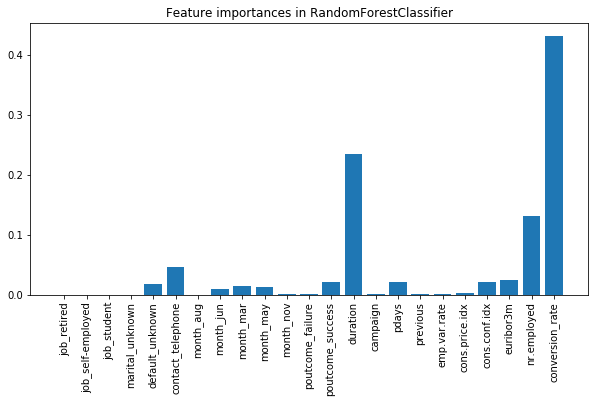

In [20]:
rfc  = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#fit,train and plot feat_importances
fit_and_train(rfc)
plt.figure(figsize=(10,5))
plt.bar(X.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

In [21]:
print(cross_val_score(rfc, X, Y, cv=10))
cross_val_score(rfc, X_test, Y_test, cv=10)

[0.99691992 1.         0.99383984 0.99093087 1.         1.
 1.         0.99110198 0.98049281 0.99418207]


array([0.98300971, 0.99878641, 0.99271845, 0.98665049, 0.98543689,
       1.        , 0.99393204, 0.99029126, 1.        , 0.9890644 ])

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
param_grid = dict(C=[0.0001,
 0.001,
 0.01,
 0.03,
 0.1,
 0.3,
 0.6,
 1,
 1.3,
 1.6,
 2,
 5,
 10,
 15,
 20,
 50,
 100])
grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   13.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 0.6, 1, 1.3, 1.6, 2, 5, 10, 15, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [24]:
#best estimator from Gridsearch
grid.best_estimator_

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

fit_and_train(lr)

----Results based only on training dataset----
Accuracy: 0.9994695414099931
predicted      0      1    All
actual                        
0          29204     16  29220
1             15  29205  29220
All        29219  29221  58440

Type I errors: 0.03%
Type II errors: 0.03%

Precision: 99.95%
Recall: 99.95%

----Results based on test dataset----
Accuracy: 0.9995144452537024
predicted     0    1   All
actual                    
0          7326    2  7328
1             2  908   910
All        7328  910  8238

Type I errors: 0.02%
Type II errors: 0.02%

Precision: 99.78%
Recall: 99.78%


In [27]:
print(cross_val_score(lr, X, Y, cv=10))
cross_val_score(lr, X_test, Y_test, cv=10)

[0.99863107 0.99965777 1.         0.99982888 0.99897331 0.99863107
 0.99914442 0.99845996 0.99914442 0.99863107]


array([0.97572816, 0.99514563, 0.98300971, 0.96359223, 0.98665049,
       0.98300971, 0.97451456, 0.97330097, 0.9671932 , 0.98298906])

### We have seen two cases of overfitting. Will now eliminate duration column

In [28]:
X = X.loc[:,X.columns != 'duration']
X_test = X_test.loc[:,X_test.columns != 'duration']

print(X.columns)

Index(['job_retired', 'job_self-employed', 'job_student', 'marital_unknown',
       'default_unknown', 'contact_telephone', 'month_aug', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'poutcome_failure',
       'poutcome_success', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'conversion_rate'],
      dtype='object')


In [46]:
#repeat of modelling
#rfc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble


rfc = ensemble.RandomForestClassifier()

params = {"n_estimators": [10, 5, 15],
              "max_depth": [3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.0]}



grid = GridSearchCV(estimator=rfc, param_grid=params, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   22.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 5, 15], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3], 'min_samples_leaf': [5, 10, 20], 'max_leaf_nodes': [20, 40], 'min_weight_fraction_leaf': [0.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [47]:
#best estimator from Gridsearch
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=40,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

----Results based only on training dataset----
Accuracy: 0.9954483230663929
predicted      0      1    All
actual                        
0          29029    191  29220
1             75  29145  29220
All        29104  29336  58440

Type I errors: 0.33%
Type II errors: 0.13%

Precision: 99.35%
Recall: 99.74%

----Results based on test dataset----
Accuracy: 0.9921097353726632
predicted     0    1   All
actual                    
0          7276   52  7328
1            13  897   910
All        7289  949  8238

Type I errors: 0.63%
Type II errors: 0.16%

Precision: 94.52%
Recall: 98.57%


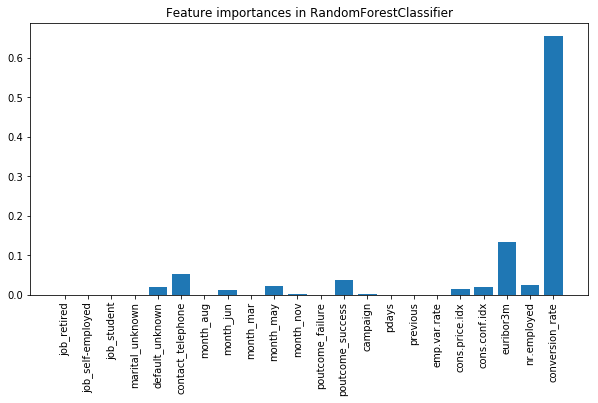

[1.         0.95242984 1.         0.96663244 0.92830253 1.
 1.         0.97724162 0.99332649 0.99811773]


array([1.        , 0.92839806, 0.96237864, 0.99393204, 0.96601942,
       0.99878641, 1.        , 0.94781553, 0.97205346, 0.95382746])

In [48]:
rfc  = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=40,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#fit,train and plot feat_importances
fit_and_train(rfc)
plt.figure(figsize=(10,5))
plt.bar(X.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()
print(cross_val_score(rfc, X, Y, cv=10))
cross_val_score(rfc, X_test, Y_test, cv=10)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
param_grid = dict(C=[0.0001,
 0.001,
 0.01,
 0.03,
 0.1,
 0.3,
 0.6,
 1,
 1.3,
 1.6,
 2,
 5,
 10,
 15,
 20,
 50,
 100])
grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   12.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 0.6, 1, 1.3, 1.6, 2, 5, 10, 15, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [50]:
#best estimator from Gridsearch
grid.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

fit_and_train(lr)

print(cross_val_score(lr, X, Y, cv=10))
cross_val_score(lr, X_test, Y_test, cv=10)

----Results based only on training dataset----
Accuracy: 0.9986995208761122
predicted      0      1    All
actual                        
0          29208     12  29220
1             64  29156  29220
All        29272  29168  58440

Type I errors: 0.02%
Type II errors: 0.11%

Precision: 99.96%
Recall: 99.78%

----Results based on test dataset----
Accuracy: 0.9991502791939791
predicted     0    1   All
actual                    
0          7327    1  7328
1             6  904   910
All        7333  905  8238

Type I errors: 0.01%
Type II errors: 0.07%

Precision: 99.89%
Recall: 99.34%
[0.99589322 0.99657769 0.99845996 0.99914442 0.99845996 0.99845996
 0.9977755  0.99845996 0.99965777 0.99691992]


array([0.99271845, 0.9842233 , 0.98300971, 0.97572816, 0.9842233 ,
       0.98058252, 0.99393204, 0.98300971, 0.97205346, 0.98663426])

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
fit_and_train(knn)

print(cross_val_score(knn, X, Y, cv=10))
print(cross_val_score(knn, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.9883641341546886
predicted      0      1    All
actual                        
0          28735    485  29220
1            195  29025  29220
All        28930  29510  58440

Type I errors: 0.83%
Type II errors: 0.33%

Precision: 98.36%
Recall: 99.33%

----Results based on test dataset----
Accuracy: 0.9700169944161204
predicted     0     1   All
actual                     
0          7143   185  7328
1            62   848   910
All        7205  1033  8238

Type I errors: 2.25%
Type II errors: 0.75%

Precision: 82.09%
Recall: 93.19%
[0.96919918 0.98083504 0.98340178 0.98203285 0.98151951 0.98237509
 0.98323066 0.98648186 0.98785079 0.98066393]
[0.94538835 0.9684466  0.96480583 0.94902913 0.96237864 0.95873786
 0.94660194 0.96601942 0.95261239 0.96597813]


In [42]:
# is it possible that oversampling based on 63 features has resulted in overfitting?
from sklearn.svm import LinearSVC
clf = LinearSVC()
fit_and_train(clf)
print(cross_val_score(clf, X, Y, cv=10))

----Results based only on training dataset----
Accuracy: 0.7517111567419575
predicted      0      1    All
actual                        
0          14973  14247  29220
1            263  28957  29220
All        15236  43204  58440

Type I errors: 24.38%
Type II errors: 0.45%

Precision: 67.02%
Recall: 99.1%

----Results based on test dataset----
Accuracy: 0.5704054382131586
predicted     0     1   All
actual                     
0          3808  3520  7328
1            19   891   910
All        3827  4411  8238

Type I errors: 42.73%
Type II errors: 0.23%

Precision: 20.2%
Recall: 97.91%
[0.7980835  0.5        0.5        0.65691307 0.60780287 0.57871321
 0.50085558 0.69353183 0.80852156 0.5       ]


### Case of overfitting? <br>
Random Forest, Logistic Regression and K-nearest neighbours produce excellent results and show little variations when subjected to cross validation (n_buckets = 10). Perhaps there is a chance that SMOTE on the larger dataset with 63 features has simulated some of the data and therefore resulted in overfitting.

In [54]:
#starting with master dataset and going from there
allfeat_df.describe()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,...,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,...,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [63]:
allfeat_df2 = allfeat_df.loc[:,['job_retired', 'job_self-employed', 'job_student', 'marital_unknown',
       'default_unknown', 'contact_telephone', 'month_aug', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'poutcome_failure',
       'poutcome_success', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed','y']]
allfeat_df2["conversion_rate"] = allfeat_df2['y']/allfeat_df2['campaign']

allfeat_df2.head()
print(allfeat_df2['conversion_rate'].unique())

[0.         1.         0.5        0.33333333 0.25       0.2
 0.16666667 0.04347826 0.09090909 0.11111111 0.1        0.06666667
 0.08333333 0.14285714 0.125      0.05882353 0.07692308 0.07142857]


In [65]:
#test/train split
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(allfeat_df2.loc[:,allfeat_df2.columns != 'y'], allfeat_df2['y'], test_size= 0.20, random_state=20)
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(32950, 22)
(32950,)
(8238, 22)
(8238,)


In [66]:
#SMOTE on dataset with reduced features
from imblearn.over_sampling import SMOTE
smote =  SMOTE(random_state = 1, ratio = 1.0)
xx = X
yy = Y

x_balanced,y_balanced = smote.fit_sample(xx,yy)

print(x_balanced.shape)
print(y_balanced.shape)

x_var = list(xx.columns)
bal_df = pd.DataFrame(data = x_balanced , columns = x_var)
bal_df.describe()

c:\users\imnus\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(58440, 22)
(58440,)


,job_retired,job_self-employed,job_student,marital_unknown,default_unknown,contact_telephone,month_aug,month_jun,month_mar,month_may,...,poutcome_success,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,conversion_rate
count,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,...,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000,58440.000000
mean,0.059090,0.028513,0.032510,0.002016,0.155722,0.272752,0.144671,0.127443,0.033429,0.272487,...,0.107158,2.323893,885.063750,0.307609,-0.494142,93.479589,-40.215049,2.966064,5135.610718,0.348557
std,0.224274,0.161015,0.165237,0.041886,0.359276,0.440859,0.351384,0.332680,0.178345,0.444967,...,0.307636,2.356915,316.491378,0.674549,1.722927,0.631813,5.336008,1.889388,86.882151,0.413152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,999.000000,0.000000,-1.800000,92.893000,-42.700000,1.244504,5076.200000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,999.000000,0.000000,-0.100000,93.444000,-41.800000,4.021000,5191.000000,0.029412
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.959000,5228.100000,0.764301
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [67]:
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(32950, 22)
(32950,)
(8238, 22)
(8238,)


In [68]:
#intializing new over sampled test dataset
X = bal_df
Y = y_balanced

print(X.shape)
print(Y.shape)

#checking if oversampling mitigated class imbalance (IT DOES!)
np.mean(y_balanced)


(58440, 22)
(58440,)


0.5

#### Final assesment of models - after SMOTE on reduced (less features) dataset <br>
We will now test and tune on rfc and logR, as well as test (without tuning) on LSVC/SCV and KNN

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble


rfc = ensemble.RandomForestClassifier()

params = {"n_estimators": [10, 5, 15],
              "max_depth": [3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.0]}



grid = GridSearchCV(estimator=rfc, param_grid=params, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   27.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 5, 15], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3], 'min_samples_leaf': [5, 10, 20], 'max_leaf_nodes': [20, 40], 'min_weight_fraction_leaf': [0.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [70]:
#best estimator from Gridsearch
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=40,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

----Results based only on training dataset----
Accuracy: 0.9951403148528405
predicted      0      1    All
actual                        
0          28936    284  29220
1              0  29220  29220
All        28936  29504  58440

Type I errors: 0.49%
Type II errors: 0.0%

Precision: 99.04%
Recall: 100.0%

----Results based on test dataset----
Accuracy: 0.9908958485069191
predicted     0    1   All
actual                    
0          7253   75  7328
1             0  910   910
All        7253  985  8238

Type I errors: 0.91%
Type II errors: 0.0%

Precision: 92.39%
Recall: 100.0%


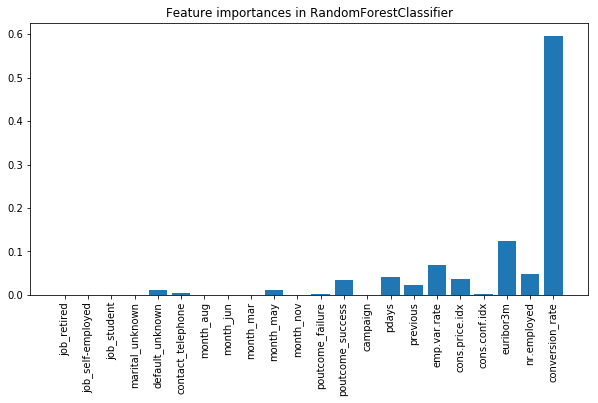

[0.88227242 0.99965777 0.99144422 0.98083504 1.         0.99794661
 1.         1.         0.99555099 1.        ]
[0.93932039 0.93932039 1.         0.94174757 0.96237864 0.97208738
 0.98907767 0.93567961 0.9963548  0.98420413]


array([2.77456223e-04, 4.66171439e-04, 2.66945680e-04, 0.00000000e+00,
       1.08323077e-02, 4.92112220e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.17186155e-02, 0.00000000e+00, 1.32277104e-03,
       3.37307404e-02, 3.33729622e-04, 4.05069192e-02, 2.25341533e-02,
       6.80866234e-02, 3.57719696e-02, 7.05001146e-04, 1.24934898e-01,
       4.74727695e-02, 5.96117806e-01])

In [85]:
rfc  = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=40,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#fit,train and plot feat_importances
fit_and_train(rfc)
plt.figure(figsize=(10,5))
plt.bar(X.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()
print(cross_val_score(rfc, X, Y, cv=10))
print(cross_val_score(rfc, X_test, Y_test, cv=10))
rfc.feature_importances_

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
param_grid = dict(C=[0.0001,
 0.001,
 0.01,
 0.03,
 0.1,
 0.3,
 0.6,
 1,
 1.3,
 1.6,
 2,
 5,
 10,
 15,
 20,
 50,
 100])
grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', verbose=3, n_jobs=-1, return_train_score=True)


grid.fit(X,Y)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   17.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 0.6, 1, 1.3, 1.6, 2, 5, 10, 15, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [82]:
#best estimator from Gridsearch
grid.best_estimator_

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

fit_and_train(lr)
print(cross_val_score(lr, X, Y, cv=10))
cross_val_score(lr, X_test, Y_test, cv=10)

----Results based only on training dataset----
Accuracy: 0.9990588637919233
predicted      0      1    All
actual                        
0          29201     19  29220
1             36  29184  29220
All        29237  29203  58440

Type I errors: 0.03%
Type II errors: 0.06%

Precision: 99.93%
Recall: 99.88%

----Results based on test dataset----
Accuracy: 0.9995144452537024
predicted     0    1   All
actual                    
0          7325    3  7328
1             1  909   910
All        7326  912  8238

Type I errors: 0.04%
Type II errors: 0.01%

Precision: 99.67%
Recall: 99.89%
[0.9967488  0.99880219 0.99914442 0.99914442 0.99845996 0.99914442
 0.99897331 0.99657769 0.99931554 0.9977755 ]


array([0.97936893, 0.99393204, 0.99393204, 0.97572816, 0.99271845,
       0.97087379, 0.99029126, 0.97936893, 0.99513973, 0.98663426])

In [75]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
fit_and_train(knn)

print(cross_val_score(knn, X, Y, cv=10))
print(cross_val_score(knn, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.990605749486653
predicted      0      1    All
actual                        
0          28750    470  29220
1             79  29141  29220
All        28829  29611  58440

Type I errors: 0.8%
Type II errors: 0.14%

Precision: 98.41%
Recall: 99.73%

----Results based on test dataset----
Accuracy: 0.9731731002670551
predicted     0     1   All
actual                     
0          7157   171  7328
1            50   860   910
All        7207  1031  8238

Type I errors: 2.08%
Type II errors: 0.61%

Precision: 83.41%
Recall: 94.51%
[0.98100616 0.98408624 0.98562628 0.98374401 0.98408624 0.98425736
 0.98391513 0.98921971 0.98921971 0.9825462 ]
[0.94538835 0.9684466  0.96480583 0.94902913 0.96237864 0.95873786
 0.94660194 0.96601942 0.95261239 0.96597813]


In [86]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
fit_and_train(clf)
print(cross_val_score(clf, X, Y, cv=10))
print(cross_val_score(clf, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.6255304585900069
predicted      0     1    All
actual                       
0          29205    15  29220
1          21869  7351  29220
All        51074  7366  58440

Type I errors: 0.03%
Type II errors: 37.42%

Precision: 99.8%
Recall: 25.16%

----Results based on test dataset----
Accuracy: 0.9141781985918912
predicted     0    1   All
actual                    
0          7326    2  7328
1           705  205   910
All        8031  207  8238

Type I errors: 0.02%
Type II errors: 8.56%

Precision: 99.03%
Recall: 22.53%
[0.53952772 0.70995893 0.7849076  0.5        0.80355921 0.5
 0.71457906 0.77703628 0.69507187 0.5       ]
[0.88956311 0.88956311 0.89805825 0.90533981 0.89805825 0.90533981
 0.88956311 0.89805825 0.11057108 0.89793439]


In [78]:
from sklearn.svm import SVC
clf = SVC()
fit_and_train(clf)
print(cross_val_score(clf, X, Y, cv=10))
print(cross_val_score(clf, X_test, Y_test, cv=10))

----Results based only on training dataset----
Accuracy: 0.982460643394935
predicted      0      1    All
actual                        
0          28782    438  29220
1            587  28633  29220
All        29369  29071  58440

Type I errors: 0.75%
Type II errors: 1.0%

Precision: 98.49%
Recall: 97.99%

----Results based on test dataset----
Accuracy: 0.9815489196406895
predicted     0     1   All
actual                     
0          7197   131  7328
1            21   889   910
All        7218  1020  8238

Type I errors: 1.59%
Type II errors: 0.25%

Precision: 87.16%
Recall: 97.69%
[0.98340178 0.98117728 0.98288843 0.97895277 0.97946612 0.98425736
 0.98203285 0.98220397 0.98134839 0.97621492]
[0.95145631 0.95631068 0.94781553 0.95631068 0.95024272 0.94296117
 0.95024272 0.9538835  0.94896719 0.95990279]


In [87]:
KNN = [0.89330768, 0.8973262,  0.89925134, 0.90074866, 0.89475936, 0.90588235,
 0.89860963, 0.89946524, 0.90224599, 0.89647059]
Random_Forest = [0.88227242, 0.99965777, 0.99144422, 0.98083504, 1,         0.99794661,
 1,         1,         0.99555099, 1]
Logistic_regression = [0.74898439, 0.74032086, 0.75058824, 0.74417112, 0.73582888,
       0.74459893, 0.75058824, 0.7428877 , 0.74973262, 0.74352941]
Linear_SVC = [0.53952772, 0.70995893, 0.7849076,  0.5,        0.80355921, 0.5,
 0.71457906, 0.77703628, 0.69507187, 0.5]
SVC = [0.98340178, 0.98117728, 0.98288843, 0.97895277, 0.97946612, 0.98425736,
 0.98203285, 0.98220397, 0.98134839, 0.97621492]


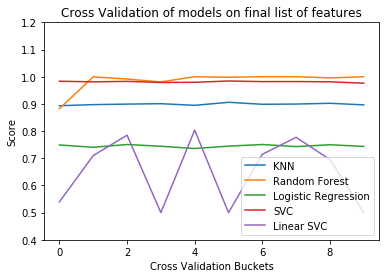

In [90]:
plt.xlabel("Cross Validation Buckets")
plt.ylabel("Score")
plt.title("Cross Validation of models on final list of features")
plt.plot(KNN, label = 'KNN')
plt.plot(Random_Forest, label = 'Random Forest')
plt.plot(Logistic_regression, label = "Logistic Regression")
plt.plot(SVC, label = 'SVC')
plt.plot(Linear_SVC, label = 'Linear SVC')
plt.plot()
plt.ylim([0.4,1.2])
plt.legend(loc = 'lower right')
plt.show()

### Conclusion from Modelling on final dataset <br>
The above results reflect the final result after running each model a few times. Inconsistent cross validation scores indicate two things: <br>
1) Overfitting <br>
2) The model(s) are unstable (Linear SVC, random forest)

In [91]:
df_num.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


### Next steps<br>
- PCA on highly correlated columns.
- More iterations of tune, feature engineer, tune process.
- Incorporate more variables/features such as race, sex, gross income, year.
- Undersampling was tried in one of the previous notebooks using the np.random.choice function. Maybe I jumped to a conclusion too quickly (bias)
- Try other ensemble models such as XGBoost
- Try mapping a nueral network